New EnbPI Bootstrap Steps:
1) Extract Data
2) Preprocess Data
3) Bootstrap Synthetic Data
4) Train Bootstrap Models
5) Aggregate Model with LOO
6) Get Nonconformity Scores, Q-hat, and Conformal Prediction Interval 
7) Evaluate Result on Test

#### **STEP 1) Extract Data**
- Solar Atlanta Data
- Solar SF Data
- SF PV Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
data_name = 'solar'
filename = "Data/Solar_Atl_data.csv"
max_data_size = 10000

In [3]:
data_df = pd.read_csv(filename, skiprows=2)
data_df.shape

(8760, 14)

In [4]:
data_df.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,Unnamed: 13
0,2018,1,1,0,30,0,0,-12.3,0.11,1.9,59.45,-5.7,989,NaN
1,2018,1,1,1,30,0,0,-12.6,0.11,1.8,59.64,-6.0,989,NaN
2,2018,1,1,2,30,0,0,-12.7,0.11,1.8,60.25,-6.2,990,NaN
3,2018,1,1,3,30,0,0,-12.8,0.11,1.9,60.54,-6.4,990,NaN
4,2018,1,1,4,30,0,0,-13.2,0.11,1.9,60.17,-6.8,991,NaN


<Axes: >

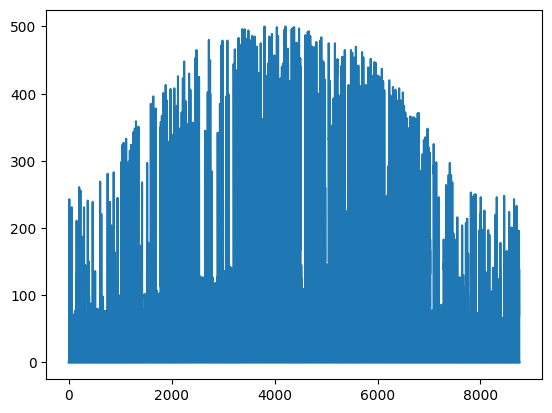

In [5]:
data_df["DHI"].plot()

#### **STEP 2) Preprocess Data**
- Strip out temporal columns from util.read_data()
- Split train/test sets
- Get AR lag coeffs with one-dim transformation (optional)

**util.read_data()**

In [6]:
if data_name == 'solar':
    # data.shape  # 8760, 14
    data_df.drop(columns=data_df.columns[0:5], inplace=True)  # Why??
    data_df.drop(columns="Unnamed: 13", inplace=True)
    # pick maximum of X data points (for speed)
    data_df = data_df.iloc[: min(max_data_size, data_df.shape[0]), :]

data_df.shape

(8760, 8)

In [7]:
data_df.head()

,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure
0,0,0,-12.3,0.11,1.9,59.45,-5.7,989
1,0,0,-12.6,0.11,1.8,59.64,-6.0,989
2,0,0,-12.7,0.11,1.8,60.25,-6.2,990
3,0,0,-12.8,0.11,1.9,60.54,-6.4,990
4,0,0,-13.2,0.11,1.9,60.17,-6.8,991


**Split Train/Test**

In [8]:
target_column = "DHI"

In [9]:
data_x = data_df.drop(target_column, axis=1)
data_y = data_df[target_column]
data_x.shape, data_y.shape
total_data_points = data_x.shape[0]
# Is this part of the code? 10%/20% train for time saving
Train_size = np.linspace(0.1 * total_data_points, 0.2 * total_data_points, 2).astype(int)
train_size = Train_size[-1]  # let's just have one train size for now

Train_size, train_size

(array([ 876, 1752]), 1752)

In [10]:
# for one-step ahead forecasting. 
# TODO: generalize this for multistep forecasting
data_y = data_y.shift(-1)
data_y.dropna(inplace=True)
data_x.drop(data_x.tail(1).index, inplace=True)
data_x_numpy = data_x.to_numpy()  # Convert to numpy
data_y_numpy = data_y.to_numpy()  # Convert to numpy

X_train = data_x_numpy[:train_size, :]
X_test = data_x_numpy[train_size:, :]
y_train = data_y_numpy[:train_size]
y_test = data_y_numpy[train_size:]

**one_dimen_transform()**

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1752, 7), (1752,), (7007, 7), (7007,))

In [12]:
# this is the AR-transformer. can replace with something from sktime.
def one_dimen_transform(y_train, y_test, d):
    n = len(y_train)
    n1 = len(y_test)
    X_train = np.zeros((n - d, d))  # from d+1,...,n
    X_test = np.zeros((n1, d))  # from n-d,...,n+n1-d
    for i in range(n - d):
        X_train[i, :] = y_train[i : i + d]
    for i in range(n1):
        if i < d:
            X_test[i, :] = np.r_[y_train[n - d + i :], y_test[:i]]
        else:
            X_test[i, :] = y_test[i - d : i]
    y_train = y_train[d:]
    return [X_train, X_test, y_train, y_test]

In [13]:
one_dim = True

if one_dim:
    # `d` is num_lookbacks for AR-transformer
    d = 24
    X_train, X_test, y_train, y_test = one_dimen_transform(
        y_train,
        y_test,
        d=d,  # 24
    )

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1728, 24), (1728,), (7007, 24), (7007,))

#### **STEP 3) Bootstrap Synthetic Data**

In [15]:
block_length = 6  # [6, 12, 24, 48, 60, 72] loop
B = 25  # [20, 25, ..., 50] single option

In [16]:
n = len(X_train)
n1 = len(X_test)
# b = 0  # (0, B=25)

#util.generate_bootstrap_samples
m = n
tot_trial = 1  # For CP methods that randomizes (for EnbPI, should be set to 1)
itrial = 0  # for tot_trial in range(tot_trial)
random_seed = B + itrial

n, n1, B, random_seed

(1728, 7007, 25, 25)

**Random Bootstrap**

In [17]:
# EnbPI.prediction_interval and fit_bootstrap_models_online

In [18]:
np.random.seed(random_seed)  # must add random 
# np.random.seed(98765 + itrial)

samples_idx = np.zeros((B, m), dtype=int)
for b in range(B):
    sample_idx = np.random.choice(a=n, size=m, replace=True)
    samples_idx[b, :] = sample_idx

samples_idx.shape

(25, 1728)

In [19]:
samples_idx

array([[1156,  318,  474, ...,  110, 1123, 1264],
       [1157,  564, 1597, ...,  698,  907, 1602],
       [ 299, 1700,  690, ..., 1337,  118, 1689],
       ...,
       [ 845,  660,  382, ...,  994,  151, 1287],
       [1056,  317,   16, ..., 1639, 1615, 1369],
       [ 672,  784, 1408, ...,  445, 1383,  640]])

**Moving BB**

In [20]:
from numpy.random import default_rng

In [21]:
samples_idx = np.zeros((B, m), dtype=int)
# np.random.seed(None)

for b in range(B):
    # bootstraps._id_mb_bootstrap()
    rng = default_rng(b + random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint

    n_blocks = int(np.ceil(n / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)

    last_block = n - block_length
    blocks = rng_integers(low=0, high=last_block, size=(n_blocks, 1), dtype=int)
    _id = (blocks + nexts).ravel()[:n]

    samples_idx[b, :] = _id

samples_idx.shape

(25, 1728)

In [22]:
samples_idx

array([[ 868,  869,  870, ..., 1614, 1615, 1616],
       [1484, 1485, 1486, ..., 1118, 1119, 1120],
       [   4,    5,    6, ..., 1672, 1673, 1674],
       ...,
       [ 167,  168,  169, ...,  878,  879,  880],
       [ 223,  224,  225, ...,  775,  776,  777],
       [  73,   74,   75, ..., 1660, 1661, 1662]])

**Circular BB**

In [23]:
samples_idx = np.zeros((B, m), dtype=int)

for b in range(B):
    # bootstraps._id_c_bootstrap()
    rng = default_rng(b + random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint

    n_blocks = int(np.ceil(n / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)

    last_block = n

    blocks = rng_integers(low=0, high=last_block, size=(n_blocks, 1), dtype=int)
    _id = np.mod((blocks + nexts).ravel(), n)[:n]

    samples_idx[b, :] = _id

samples_idx.shape

(25, 1728)

In [24]:
samples_idx

array([[ 871,  872,  873, ..., 1619, 1620, 1621],
       [1489, 1490, 1491, ..., 1121, 1122, 1123],
       [   4,    5,    6, ..., 1678, 1679, 1680],
       ...,
       [ 168,  169,  170, ...,  881,  882,  883],
       [ 224,  225,  226, ...,  778,  779,  780],
       [  73,   74,   75, ..., 1666, 1667, 1668]])

**Stationary BB**

In [25]:
samples_idx = np.zeros((B, m), dtype=int)

for b in range(B):
    # bootstraps._id_s_bootstrap()
    rng = default_rng(b + random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint
    #
    rng_poisson = rng.poisson
    #
    random_block_length = rng_poisson(lam=block_length, size=n)
    random_block_length[random_block_length < 3] = 3
    random_block_length[random_block_length >= n] = n
    random_block_length = random_block_length[random_block_length.cumsum() <= n]
    residual_block = n - random_block_length.sum()
    if residual_block > 0:
        random_block_length = np.append(random_block_length, residual_block)
    #
    n_blocks = random_block_length.shape[0]
    nexts = np.zeros((n_blocks, random_block_length.max() + 1))
    nexts[np.arange(n_blocks), random_block_length] = 1
    nexts = np.flip(nexts, 1).cumsum(1).cumsum(1).ravel()
    nexts = (nexts[nexts > 1] - 2).astype(int)
    #
    last_block = n - random_block_length.max()
    blocks = np.zeros(n, dtype=int)
    if last_block > 0:
        blocks = rng_integers(low=0, high=last_block, size=n_blocks)
        blocks = np.repeat(blocks, random_block_length)
    _id = blocks + nexts
    #
    samples_idx[b, :] = _id

samples_idx.shape

(25, 1728)

In [26]:
samples_idx

array([[1236, 1237, 1238, ...,  631,  863,  864],
       [ 753,  754,  755, ..., 1295, 1296, 1297],
       [1276, 1277, 1278, ..., 1463, 1464, 1465],
       ...,
       [ 907,  908,  909, ...,  871,  872,  873],
       [ 347,  348,  349, ..., 1491, 1279, 1280],
       [1366, 1367, 1368, ..., 1088, 1089, 1513]])

#### **STEP 4) Train Bootstrap Models**

In [33]:
# bootstrap_types, block_lengths
# bootstrap_types = ["circular", "stationary", "moving", "random"]#, "random"]
# bootstrap_types = ["random"]
# block_lengths = [6, 12, 24, 48, 60, 72]

In [34]:
#alpha_ls = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]#np.linspace(0.05, 0.50, 10)
alpha_ls = [0.01, 0.10, 0.20, 0.50, 0.80, 0.90, 0.99]  #np.linspace(0.05, 0.50, 10)
stride = 1

In [35]:
target_column = "DHI"

In [ ]:
# Then run conformal-related methods
stride = 1
miss_test_idx = []
#alpha = 0.1
#rnn = True
methods = ['Ensemble']#, 'ICP', 'Weighted_ICP']
bootstrap_types = ["circular", "stationary", "moving", "random"]#, "random"]
block_lengths = [6, 12, 24, 48, 60, 72]
# NOTE, if want to run J+aB (Kim et al. 2020), then let
# methods = ['Ensemble', 'ICP', 'Weighted_ICP', 'JaB']

**Run Boostrap**

In [ ]:
results_col = [
    "itrial",
    "dataname",
    "muh_fun",
    "method",
    "train_size",
    "alpha",
    "coverage",
    "width",
    "bootstrap_type",
    "block_length",
]
results_df = pd.DataFrame(columns=results_col)

In [ ]:
itrial = 0
np.random.seed(98765 + itrial)  # does this do anything?

In [ ]:
train_size

1752

In [ ]:
data_y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: DHI, dtype: float64

In [ ]:
X_train.shape, X_test.shape

((1752, 7), (7007, 7))

**Models**

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [ ]:
min_alpha = 0.0001
max_alpha = 10

In [ ]:
ridge_cv = RidgeCV(alphas=np.linspace(min_alpha, max_alpha, 10))
lasso_cv = LassoCV(alphas=np.linspace(min_alpha, max_alpha, 10))
random_forest = RandomForestRegressor(
    n_estimators=10, criterion="squared_error", bootstrap=False, max_depth=2, n_jobs=-1
)
extra_trees = ExtraTreesRegressor(n_estimators=10, criterion="squared_error", bootstrap=False, max_depth=2, n_jobs=-1)

In [44]:
from tensorflow import keras
# import keras
# from keras.models import Sequential, clone_model
# from keras.layers import Dense
# from keras.layers import Dropout
# from tensorflow.keras.optimizers import Adam

2023-05-16 17:41:48.222170: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 17:41:48.436388: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 17:41:48.437332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 17:41:49.882015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [45]:
regressor = lasso_cv
regressor

LassoCV(alphas=array([1.0000e-04, 1.1112e+00, 2.2223e+00, 3.3334e+00, 4.4445e+00,
       5.5556e+00, 6.6667e+00, 7.7778e+00, 8.8889e+00, 1.0000e+01]))

In [46]:
# hold predictions from each f^b
boot_testions = np.zeros((B, (n + n1)), dtype=float)
# for i^th column, it shows which f^b uses i in training (so exclude in aggregation)
in_boot_sample = np.zeros((B, n), dtype=bool)
out_sample_test = np.zeros((n, n1))

In [47]:
for b in range(B):
    model = regressor
    X_train_boot = X_train[boot_samples_idx[b], :]
    y_train_boot = y_train[boot_samples_idx[b],]
    # print(X_train_boot.shape)
    # print(y_train_boot.shape)
    callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
    bsize = int(0.1 * len(np.unique(boot_samples_idx[b])))

    model.fit(
        X_train_boot,
        y_train_boot,
        # epochs=10,
        # batch_size=bsize,
        # callbacks=[callback],
        # verbose=0,
    )

    boot_testions[b] = model.predict(
        np.r_[X_train, X_test]
    ).flatten()
    in_boot_sample[b, boot_samples_idx[b]] = True

**Output**

In [48]:
X_train_boot.shape, y_train_boot.shape, X_train_boot.shape, y_train_boot.shape

((1728, 24), (1728,), (1728, 24), (1728,))

In [49]:
boot_testions.shape

(25, 8735)

In [50]:
boot_samples_idx

array([[ 684,  559, 1653, ...,  740, 1439,  350],
       [1353,  364, 1200, ..., 1583,  859, 1024],
       [ 163, 1050, 1214, ...,  668,  790, 1691],
       ...,
       [1674,  764,  890, ...,  748, 1448,  167],
       [1261, 1460,  437, ..., 1638, 1373, 1181],
       [1593,  740, 1068, ..., 1001,  725,  972]])

In [51]:
in_boot_sample.shape

(25, 1728)

In [52]:
in_boot_sample

array([[ True, False, False, ..., False, False,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True, False,  True],
       ...,
       [ True,  True,  True, ...,  True, False,  True],
       [False, False, False, ...,  True, False,  True],
       [ True,  True, False, ..., False, False,  True]])

#### **STEP 5) LOO**

In [53]:
i = 0

In [54]:
in_boot_sample

array([[ True, False, False, ..., False, False,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True, False,  True],
       ...,
       [ True,  True,  True, ...,  True, False,  True],
       [False, False, False, ...,  True, False,  True],
       [ True,  True, False, ..., False, False,  True]])

In [55]:
in_boot_sample[:, 0]

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True,  True, False,  True,  True, False,  True])

In [56]:
b_keep = np.argwhere(~(in_boot_sample[:, i])).reshape(-1)
b_keep  # bootstraps models to keep to evaluate i 

array([ 2, 11, 12, 17, 20, 23])

In [57]:
boot_testions.shape, boot_testions[b_keep, i].shape

((25, 8735), (6,))

In [58]:
Ensemble_train_interval_centers = ([])

In [59]:
# if there is bootstraps, in this case yes
# if len(b_keep) > 0:
Ensemble_train_interval_centers.append(
    boot_testions[b_keep, i].mean()  # aggregation
)
Ensemble_train_interval_centers  # aggregates the predictions for the 6 models for i=0

[4.1180101973221745]

In [60]:
len(y_train), y_train

(1728, array([0., 0., 0., ..., 0., 0., 0.]))

In [61]:
y_train[i]

0.0

In [63]:
y_train.shape, boot_testions.shape

((1728,), (25, 8735))

In [62]:
y_train[i].shape, boot_testions[b_keep, i].shape  # should swap dimensions??

((), (6,))

In [87]:
resid_LOO = y_train[i] - boot_testions[b_keep, i].mean()
# out_sample_test[i] = boot_testions[b_keep, n:].mean(0)

In [64]:
out_sample_test[i] = boot_testions[b_keep, n:].mean(0)

In [66]:
out_sample_test.shape

(1728, 7007)

In [45]:
start = time.time()
keep = []
for i in range(n):  # n is len(X_train)
    # TO-DO

IndentationError: expected an indented block (2993820098.py, line 4)